# Trying to get learning of angles working, now with probabilities

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "proto_gen_model.ipynb"
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"

from typing import Optional, Union

from ml_collections import config_dict
import jax.random as random
import jax.numpy as jnp

jnp.log(jnp.exp(1) - 1.0)
# TODO: figure out why we get CUDA failures this ^ isn't here. 

import flax
from flax.training import train_state

import ciclo
import optax
import distrax

import jax
from jax import lax
import flax
import flax.linen as nn
flax.config.update('flax_use_orbax_checkpointing', True)

from clu import parameter_overview

from typing import Any

from functools import partial

import tensorflow_datasets as tfds

from clu import deterministic_data
from clu import preprocess_spec
from clu import metrics

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

from src.utils.preprocess import all_ops
from src.transformations import transform_image


PRNGKey = Any

2023-09-09 15:53:42.592156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
rng = random.PRNGKey(0)
train_data_rng, val_data_rng, init_rng, state_rng = random.split(rng, 4)

## Get data

In [3]:
ANGLE = 180

config = config_dict.ConfigDict()

config.batch_size = 512
config.dataset = "MNIST"
config.shuffle_buffer_size = 50_000
config.repeat_after_batching = True  # NOTE: ordering of PP, shuffle, and repeat is important!
config.train_split = f"train[10000:]"
config.pp_train = f'value_range(-1, 1)|random_rotate(-{ANGLE}, {ANGLE}, fill_value=-1)|keep(["image"])'
config.val_split = f"train[:10000]"
config.pp_eval = f'value_range(-1, 1)|random_rotate(-{ANGLE}, {ANGLE}, fill_value=-1)|keep(["image", "label"])'


config.model = config_dict.ConfigDict()
config.model.bounds = (0.25, 0.25, jnp.pi, 0.25, 0.25)
config.model.offset = (0.0, 0.0, 0.0, 0.0, 0.0)
config.model.inference = config_dict.ConfigDict()
config.model.inference.hidden_dims = (1024, 512, 256, 128)
config.model.generative = config_dict.ConfigDict()
config.model.generative.hidden_dims = (1024, 512, 256)
config.model.generative.num_flows = 2
config.model.generative.num_bins = 4
config.model.generative.conditioner = config_dict.ConfigDict()
config.model.generative.conditioner.hidden_dims = (256, 256)
config.model.generative.dropout_rate = 0.01


In [4]:
(3 * config.model.generative.num_bins + 1) * len(config.model.bounds)

65

In [5]:
def get_data(config):
    dataset_builder = tfds.builder(config.dataset)
    dataset_builder.download_and_prepare()

    local_batch_size  = config.batch_size // jax.device_count()

    train_ds = deterministic_data.create_dataset(
        dataset_builder,
        split=tfds.split_for_jax_process(config.train_split),
        # This RNG key will be used to derive all randomness in shuffling, data
        # preprocessing etc.
        rng=train_data_rng,
        shuffle_buffer_size=config.shuffle_buffer_size,
        # Depending on TPU/other runtime, local device count will be 8/1.
        batch_dims=[jax.local_device_count(), local_batch_size],
        repeat_after_batching=False,
        preprocess_fn=preprocess_spec.parse(
            spec=config.pp_train,
            available_ops=all_ops(),
        ),
        shuffle="loaded",
        )


    num_val_examples = dataset_builder.info.splits[config.val_split].num_examples
    # Compute how many batches we need to contain the entire val set.
    pad_up_to_batches = int(jnp.ceil(num_val_examples / config.batch_size))

    val_ds = deterministic_data.create_dataset(
        dataset_builder,
        split=tfds.split_for_jax_process(config.val_split),
        rng=val_data_rng,
        batch_dims=[jax.local_device_count(), local_batch_size],
        num_epochs=1,
        preprocess_fn=preprocess_spec.parse(
            spec=config.pp_eval,
            available_ops=all_ops(),
        ),
        # Pad with masked examples instead of dropping incomplete final batch.
        pad_up_to_batches=pad_up_to_batches,
        shuffle=False)

    return train_ds, val_ds

In [6]:
train_ds, val_ds = get_data(config)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': '

## Setup TrainState and NN

In [7]:
@flax.struct.dataclass  # <-- required for JAX transformations
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')
    x_mse: metrics.Average.from_output('x_mse')
    log_p_η_x_hat: metrics.Average.from_output('log_p_η_x_hat')
    mae: metrics.Average.from_output('mae')
    η_grad: metrics.Average.from_output('η_grad')
    

    def update(self, **kwargs) -> "Metrics":
        updates = self.single_from_model_output(**kwargs)
        return self.merge(updates)

class TrainState(train_state.TrainState):
    metrics: Metrics
    rng: PRNGKey
    λ: float
    λ_schedule: optax.Schedule = flax.struct.field(pytree_node=False)
    α: float
    α_schedule: optax.Schedule = flax.struct.field(pytree_node=False)
    β: float
    β_schedule: optax.Schedule = flax.struct.field(pytree_node=False)
    polyak_step_size: Optional[float] = None
    avg_params: Optional[flax.core.FrozenDict] = None

    def apply_gradients(self, *, grads, **kwargs):
        updates, new_opt_state = self.tx.update(grads, self.opt_state, self.params)
        new_params = optax.apply_updates(self.params, updates)

        if self.polyak_step_size is not None:
            new_avg_params = optax.incremental_update(new_params, self.avg_params, self.polyak_step_size)
        else:
            new_avg_params = None

        return self.replace(
            step=self.step + 1,
            params=new_params,
            opt_state=new_opt_state,
            λ=self.λ_schedule(self.step),
            α=self.α_schedule(self.step),
            β=self.β_schedule(self.step),
            avg_params=new_avg_params,
            **kwargs,
        )

    @classmethod
    def create(
        cls,
        *,
        apply_fn,
        params,
        tx,
        λ_schedule,
        α_schedule,
        β_schedule,
        **kwargs,
    ):
        opt_state = tx.init(params)
        if kwargs.get("polyak_step_size", None) is not None:
            avg_params = params
        else:
            avg_params = None
        return cls(
            step=0,
            apply_fn=apply_fn,
            params=params,
            tx=tx,
            opt_state=opt_state,
            λ_schedule=λ_schedule,
            λ=λ_schedule(0),
            α_schedule=α_schedule,
            α=α_schedule(0),
            β_schedule=β_schedule,
            β=β_schedule(0),
            avg_params=avg_params,
            **kwargs,
        )

def reset_metrics(state):
    return state.replace(metrics=state.metrics.empty())

In [8]:
from typing import Callable, Mapping, Optional, Sequence
from chex import Array, PRNGKey
import numpy as np
from flax.linen import initializers as init

KwArgs = Mapping[str, Any]

INV_SOFTPLUS_1 = jnp.log(jnp.exp(1) - 1.0)


def approximate_mode(
    distribution: distrax.Distribution, num_samples: int, rng: PRNGKey
) -> Array:
    """Approximates the mode of a distribution by taking a number of samples and returning the most likely.

    Args:
        distribution: A distribution.
        num_samples: The number of samples to take.
        rng: A PRNG key.

    Returns:
        An approximate mode.
    """
    samples, log_probs = distribution.sample_and_log_prob(
        seed=rng, sample_shape=(num_samples,)
    )
    return samples[jnp.argmax(log_probs)]


class TransformationInferenceNet(nn.Module):
    event_shape: Sequence[int]
    hidden_dims: Sequence[int]
    bounds_array: Array
    offset_array: Array
    σ_init: Callable = init.constant(jnp.log(jnp.exp(.01) - 1.0))

    @nn.compact
    def __call__(self, x, train: bool = False):
        h = x.flatten()

        for hidden_dim in self.hidden_dims:
            h = nn.Dense(hidden_dim)(h)
            h = nn.relu(h)
    
        output_dim = np.prod(self.event_shape)
        μ = nn.Dense(output_dim)(h)

        # return jax.nn.tanh(μ) * self.bounds_array

        # σ = jax.nn.softplus(nn.Dense(output_dim, name='σ_')(h)) 
        σ = jax.nn.softplus(self.param("σ_", self.σ_init, self.event_shape))

        # sample = distrax.Normal(loc=μ, scale=σ).sample(seed=self.make_rng('sample'))
        # return jax.nn.tanh(sample) * self.bounds_array

        base = distrax.Independent(
            distrax.Normal(loc=μ, scale=σ),
            len(self.event_shape)
        )

        bijector = distrax.Chain([
            distrax.Block(
                distrax.ScalarAffine(
                    shift=self.offset_array, scale=self.bounds_array
                ),
                len(self.event_shape)
            ),
            distrax.Block(distrax.Tanh(), len(self.event_shape)),
        ])
    
        return distrax.Transformed(base, bijector)


class Conditioner(nn.Module):
    """A neural network that predicts the parameters of a flow given an input."""
    event_shape: Sequence[int]
    num_bijector_params: int
    hidden_dims: Sequence[int]
    train: Optional[bool] = None

    @nn.compact
    def __call__(self, x: Array, train: Optional[bool] = None) -> Array:
        train = nn.merge_param("train", self.train, train)

        h = x.flatten()

        for hidden_dim in self.hidden_dims:
            h = nn.Dense(hidden_dim)(h)
            h = nn.relu(h)

        # We initialize this dense layer to zero so that the flow is initialized to the identity function.
        y = nn.Dense(
            np.prod(self.event_shape) * self.num_bijector_params,
            kernel_init=init.zeros,
            bias_init=init.zeros,
        )(h)
        y = y.reshape(tuple(self.event_shape) + (self.num_bijector_params,))

        return y


class TransformationGenerativeNet(nn.Module):
    event_shape: Sequence[int]
    hidden_dims: Sequence[int]
    bounds_array: Array
    offset_array: Array
    num_flows: int
    num_bins: int
    conditioner: Optional[KwArgs] = None
    ε: float = 1e-6
    dropout_rate: float = 0.0

    @nn.compact
    def __call__(self, x_hat, train: bool = False):
        h = x_hat.flatten()

        # add input dropout
        h = nn.Dropout(rate=self.dropout_rate)(h, deterministic=not train)

        # shared feature extractor
        for hidden_dim in self.hidden_dims:
            h = nn.Dense(hidden_dim)(h)
            h = nn.relu(h)
    
        # base distribution
        base_hidden = nn.Dense(hidden_dim // 2)(h)
        base_hidden = nn.relu(base_hidden)
        base_hidden = nn.Dense(hidden_dim // 2)(base_hidden)
        base_hidden = nn.relu(base_hidden)

        output_dim = np.prod(self.event_shape)
        μ = nn.Dense(output_dim)(base_hidden)
        σ = jax.nn.softplus(nn.Dense(output_dim, name='σ_')(base_hidden)) 
        base = distrax.Independent(
            distrax.Normal(loc=μ, scale=σ),
            len(self.event_shape)
        )

        # bijector
        # Number of parameters for the rational-quadratic spline:
        # - `num_bins` bin widths
        # - `num_bins` bin heights
        # - `num_bins + 1` knot slopes
        # for a total of `3 * num_bins + 1` parameters.
        num_bijector_params = 3 * self.num_bins + 1

        layers = []
        for _ in range(self.num_flows):
            params = Conditioner(
                event_shape=self.event_shape,
                num_bijector_params=num_bijector_params,
                train=train,
                **(self.conditioner or {}),
            )(h)
            layer = distrax.Block(
                distrax.RationalQuadraticSpline(params, range_min=-3.0, range_max=3.0),
                len(self.event_shape),
            )
            layers.append(layer)

        bijector = distrax.Chain([
            distrax.Block(
                distrax.ScalarAffine(
                    shift=self.offset_array, scale=self.bounds_array + self.ε
                ),
                len(self.event_shape)
            ),
            distrax.Block(distrax.Tanh(), len(self.event_shape)),
            # We invert the flow so that the `forward` method is called with `log_prob`.
            distrax.Inverse(distrax.Chain(layers)),
        ])
    
        return distrax.Transformed(base, bijector)
    
    
class PrototypicalGenerativeModel(nn.Module):
    bounds: Sequence[int]
    offset: Optional[Sequence[int]] = None
    inference: Optional[KwArgs] = None
    generative: Optional[KwArgs] = None

    def setup(self) -> None:
        self.bounds_array = jnp.array(self.bounds)
        self.offset_array = (
            jnp.array(self.offset)
            if self.offset is not None
            else jnp.zeros_like(self.bounds_array)
        )
        self.event_shape = self.bounds_array.shape
        self.inference_net = TransformationInferenceNet(
            event_shape=self.event_shape,
            bounds_array=self.bounds_array,
            offset_array=self.offset_array,
            **(self.inference or {}),
        )
        self.generative_net = TransformationGenerativeNet(
            event_shape=self.event_shape,
            bounds_array=self.bounds_array,
            offset_array=self.offset_array,
            **(self.generative or {}),
        )

    
    def __call__(self, x, train: bool = False):
        q_H_x = self.inference_net(x, train=train)
        η = q_H_x.sample(seed=self.make_rng('sample'))

        x_hat = transform_image(x, -η)

        p_H_x_hat = self.generative_net(x_hat, train=train)
        log_p_η_x_hat = p_H_x_hat.log_prob(η)

        return η, log_p_η_x_hat
    
    def generative_net_ll(self, x_hat, η, train: bool = False):
        p_H_x_hat = self.generative_net(x_hat, train=train)
        return p_H_x_hat.log_prob(η)

In [9]:
# model.apply(variables, jnp.ones((28, 28, 1)), train=False, rngs={"sample": random.PRNGKey(0)})

In [10]:
model = PrototypicalGenerativeModel(**config.model.to_dict())

variables = model.init({'params': init_rng, 'sample': init_rng}, jnp.empty((28, 28, 1)), train=False)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+----------------------------------------------------+-------------+---------+-----------+--------+
| Name                                               | Shape       | Size    | Mean      | Std    |
+----------------------------------------------------+-------------+---------+-----------+--------+
| params/generative_net/Conditioner_0/Dense_0/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/generative_net/Conditioner_0/Dense_0/kernel | (256, 256)  | 65,536  | 0.000148  | 0.0626 |
| params/generative_net/Conditioner_0/Dense_1/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/generative_net/Conditioner_0/Dense_1/kernel | (256, 256)  | 65,536  | -0.000157 | 0.0623 |
| params/generative_net/Conditioner_0/Dense_2/bias   | (65,)       | 65      | 0.0       | 0.0    |
| params/generative_net/Conditioner_0/Dense_2/kernel | (256, 65)   | 16,640  | 0.0       | 0.0    |
| params/generative_net/Conditioner_1/Dense_0/bias   | (256,)      | 256     | 0.0       

In [11]:
TOTAL_STEPS = 10_000
LR = 1e-4
N_SAMPLES = 5
POLYAK_STEP_SIZE = None

params = flax.core.freeze(variables["params"])

def lr_schedule(init_lr, peak_mult, final_mult, peak_steps, total_steps=TOTAL_STEPS): 
    return optax.warmup_cosine_decay_schedule(
        init_lr, init_lr*peak_mult, peak_steps, total_steps, end_value=init_lr*final_mult
    )

def clipped_adamw(learning_rate, norm):
    return optax.MultiSteps(optax.chain(
        optax.clip_by_global_norm(norm),
        optax.adamw(learning_rate=learning_rate)
    ), 1)


from flax import traverse_util
# partition_optimizers = {
#     "inference": optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 3, 1/30, TOTAL_STEPS//10), 2.),
#     "σ": optax.inject_hyperparams(optax.adam)(lr_schedule(LR * 100, 3, 1/3, TOTAL_STEPS//10)),
#     # "generative": optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 3, 1/30, TOTAL_STEPS//10), 2.),
#     "generative": optax.inject_hyperparams(clipped_adamw)(
#         optax.join_schedules([
#             optax.constant_schedule(0.),
#             optax.linear_schedule(LR, LR*3, TOTAL_STEPS * 3 // 40),
#             optax.cosine_decay_schedule(LR*3, TOTAL_STEPS * 27 // 40, (LR / 30) / (LR*3)),
#         ], [TOTAL_STEPS//4, TOTAL_STEPS//4 + TOTAL_STEPS * 3 // 40]),
#         2.
#     ),
# }

partition_optimizers = {
    "inference": optax.inject_hyperparams(clipped_adamw)(
        optax.join_schedules([
            lr_schedule(LR, 3, 1/30, TOTAL_STEPS//10),
            optax.constant_schedule(0.),
        ], [TOTAL_STEPS,]),
        2.
    ),
    "σ": optax.inject_hyperparams(optax.adam)(
        optax.join_schedules([
            lr_schedule(LR * 100, 3, 1/3, TOTAL_STEPS//10),
            optax.constant_schedule(0.),
        ], [TOTAL_STEPS,])
    ),
    "generative": optax.inject_hyperparams(clipped_adamw)(
        optax.join_schedules([
            optax.constant_schedule(0.),
            lr_schedule(LR * 3, 9, 1/300, TOTAL_STEPS//10, total_steps=TOTAL_STEPS),
        ], [TOTAL_STEPS,]),
        2.
    ),
}

def get_partition(path, value):
    if "generative_net" in path:
        return "generative"
    
    if "inference_net" in path:
        if "σ_" in path:
            return "σ"
        
        return "inference"

param_partitions = flax.core.freeze(traverse_util.path_aware_map(get_partition, params))
opt = optax.multi_transform(partition_optimizers, param_partitions)


state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    # tx=optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 3, 1/30, TOTAL_STEPS//10), 2.),
    tx=opt,
    metrics=Metrics.empty(),
    rng=state_rng,
    # λ_schedule=optax.cosine_decay_schedule(1., TOTAL_STEPS, 1.),
    # λ_schedule=optax.linear_schedule(0., 1., TOTAL_STEPS, TOTAL_STEPS//2),
    λ_schedule=optax.join_schedules([
        optax.constant_schedule(0.),
        optax.constant_schedule(1.),
    ], [TOTAL_STEPS,]),
    α_schedule=
    optax.join_schedules([
        optax.constant_schedule(1.),
        optax.cosine_decay_schedule(1., TOTAL_STEPS // 4, .0),
    ], [TOTAL_STEPS,]),
    β_schedule=optax.join_schedules([
        optax.constant_schedule(1.),
        optax.cosine_decay_schedule(1., TOTAL_STEPS, 0.99),
        # optax.constant_schedule(1.),
    ], [TOTAL_STEPS,]),
    polyak_step_size=POLYAK_STEP_SIZE,
)

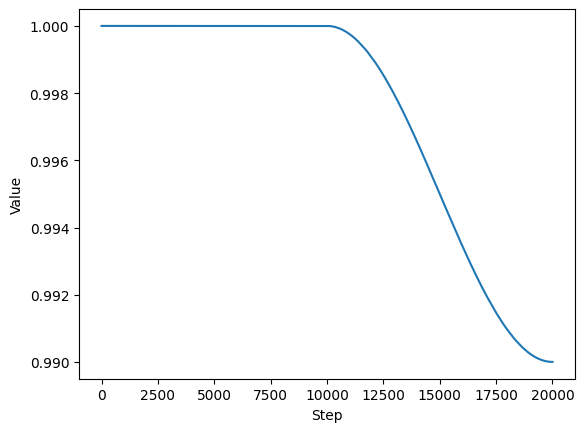

In [12]:
# helper function to plot an optax LR shedule
def plot_lr_schedule(lr_schedule, total_steps=TOTAL_STEPS * 2 + 1):
    steps = np.arange(total_steps)
    lrs = [lr_schedule(step) for step in steps]
    plt.plot(steps, lrs)
    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.show()

plot_lr_schedule(state.β_schedule)

In [13]:
def loss_fn(
    x, params, state, step_rng, train, n_samples,
):
    """Self-supervised loss function. 
    
    The loss can be summarised with the following diagram

            x ------- -η_x -----> x_hat
            |                       |
            |                       v
         η_rand                    mse
            |                       ∧
            ∨                       |
         x_rand --- -η_x_rand ---> x_hat'.

    However, implementing this directly requires doing 3 affine transformations, which adds 'blur' to the image.
    So instead we note that the diagram above is equivalent to

            x --------> mse <------- x'
            |                        ∧
            |                        |
         η_rand                     η_x
            |                        |
            v                        |
         x_rand --- -η_x_rand ---> x_hat'.

    Finally, this computation can be simplified to

            x --------> mse <-------- x'
            |                         ∧
            └ η_rand - η_x_rand + η_x ┘

    which contains only a single transformation.

    """
    rng_local = random.fold_in(step_rng, lax.axis_index("batch"))
    
    def per_sample_loss(rng):
        rng_sample1, rng_sample2, rng_η_rand, = random.split(rng, 3)

        η_x, _ = state.apply_fn(
            {"params": params}, x, train, rngs={"sample": rng_sample1, "dropout": rng_η_rand}
        )

        Η_rand = distrax.Uniform(
            low=-jnp.array(config.model.bounds) + jnp.array(config.model.offset),
            high=jnp.array(config.model.bounds) + jnp.array(config.model.offset)
        )
        η_rand = Η_rand.sample(seed=rng_η_rand, sample_shape=())

        x_rand = transform_image(x, η_rand)
        η_x_rand, _ = state.apply_fn(
            {"params": params}, x_rand, train, rngs={"sample": rng_sample2, "dropout": rng_η_rand}
        )

        x_mse = optax.squared_error(x, transform_image(x, η_rand - η_x_rand + η_x)).mean()

        difficulty = optax.squared_error(x, x_rand).mean()


        rng_η_rand1, rng_η_rand2 = random.split(rng_η_rand, 2)
        mul = 0.01 if train else 0.
        # mul = 0.
        x_hat = jax.lax.stop_gradient(transform_image(x, η_rand - η_x_rand + Η_rand.sample(seed=rng_η_rand1, sample_shape=()) * mul))
        # add a smnall amount of noise to x_hat
        mul = 0.01 if train else 0.
        # mul = 0.
        x_hat = x_hat + random.normal(rng_η_rand2, x_hat.shape) * mul

        def get_log_p_η_x_hat(η_x):
            return model.apply(
                {"params": params},
                x_hat, η_x, train=train,
                method=model.generative_net_ll,
                rngs={"dropout": rng_η_rand2}
            )
        
        log_p_η_x_hat, η_grad = jax.value_and_grad(get_log_p_η_x_hat)(jax.lax.stop_gradient(η_x))
        
        # log_p_η_x_hat = model.apply(
        #     {"params": params},
        #     jax.lax.stop_gradient(transform_image(x, -η_x)),
        #     jax.lax.stop_gradient(η_x), train=train,
        #     method=model.generative_net_ll
        # )

        return x_mse, difficulty, log_p_η_x_hat, jnp.abs(η_grad).mean()
    
    rngs = random.split(rng_local, n_samples)
    x_mse, difficulty, log_p_η_x_hat, η_grad = jax.vmap(per_sample_loss)(rngs)
    
    # do a weighted average based on the difficulty of the sample
    weights = difficulty / difficulty.sum() if train else jnp.ones_like(difficulty) / n_samples
    x_mse, = jax.tree_map(lambda x: (x * weights).sum(axis=0), (x_mse,))
    
    pairwise_diffs = jax.vmap(jax.vmap(lambda x, y: x - y, in_axes=(0, None)), in_axes=(None, 0))(log_p_η_x_hat, log_p_η_x_hat)
    mae = jnp.abs(pairwise_diffs).mean()

    log_p_η_x_hat, η_grad = jax.tree_map(lambda x: x.mean(axis=0), (log_p_η_x_hat, η_grad))

    loss = x_mse - log_p_η_x_hat * state.λ + mae * (1 - state.α) + η_grad * (1 - state.β)

    return loss, {"loss": loss, "x_mse": x_mse, "log_p_η_x_hat": log_p_η_x_hat, "mae": mae, "η_grad": η_grad}

In [14]:
foo = jnp.arange(4)
bar = foo/10

pairwise_diffs = jax.vmap(jax.vmap(lambda x, y: x - y, in_axes=(0, None)), in_axes=(None, 0))(bar, bar)

jnp.abs(pairwise_diffs).mean()

Array(0.125, dtype=float32)

In [15]:
@jax.jit
def train_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, True, N_SAMPLES,
        )

        avg_loss = losses.mean(axis=0)

        return avg_loss, metrics

    (_, metrics), grads = jax.value_and_grad(batch_loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    metrics = state.metrics.update(
        **metrics
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())
    logs.add_entry("schedules", "λ", state.λ)
    logs.add_entry("schedules", "α", state.α)
    logs.add_entry("schedules", "β", state.β)
    # logs.add_entry("schedules", "lr", state.opt_state.hyperparams["learning_rate"])
    logs.add_entry("schedules", "lr_inference", state.opt_state.inner_states['inference'][0].hyperparams["learning_rate"])
    logs.add_entry("schedules", "lr_generative", state.opt_state.inner_states['generative'][0].hyperparams["learning_rate"])
    logs.add_entry("schedules", "lr_σ", state.opt_state.inner_states['σ'][0].hyperparams["learning_rate"])
    logs.add_entry("gradients", "grad_norm", optax.global_norm(grads))
    reduce_grads = lambda tree: jax.tree_util.tree_reduce(lambda x, y: jnp.abs(y).sum() + x, tree, 0)
    logs.add_entry("gradients", "gen_sum", reduce_grads(grads['generative_net']))
    logs.add_entry("gradients", "inf_sum", reduce_grads(grads['inference_net']))

    return logs, state.replace(metrics=metrics)


@jax.jit
def eval_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    masks = batch["mask"][0]

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, False, N_SAMPLES,
        )

        avg_loss = (losses * masks).sum(axis=0) / masks.sum(axis=0)

        return avg_loss, metrics

    # _, metrics = batch_loss_fn(state.params)
    _, metrics = batch_loss_fn(state.params if state.avg_params is None else state.avg_params)

    metrics = state.metrics.update(
        **metrics, mask=masks
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())

    return logs, state.replace(metrics=metrics)

In [16]:
final_state, history, _ = ciclo.train_loop(
    state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=TOTAL_STEPS // 100,
    callbacks=[
        ciclo.keras_bar(total=TOTAL_STEPS * 2),
        # ciclo.early_stopping("loss_test", patience=TOTAL_STEPS // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=TOTAL_STEPS * 2 + 1,
)

20000/20000 [==============================] - 519s 26ms/step - log_p_η_x_hat: 5.1688 - loss: -4.4423 - mae: 0.3793 - x_mse: 0.1976 - η_grad: 14.9656 - log_p_η_x_hat_test: 5.1534 - loss_test: -4.4123 - mae_test: 0.3776 - x_mse_test: 0.1971 - η_grad_test: 16.6400: 8:33:35 - log_p_η_x_hat: 1.4141 - loss: 0.4375 - mae: 0.1519 - x_mse: 0.4375 - η_grad: 2.3879 - log_p_η_x_hat_test: 1.9060 - loss_test: 0.4542 - mae_test: 0. - ETA: 1:40:55 - log_p_η_x_hat: 1.2268 - loss: 0.3876 - mae: 0.1827 - x_mse: 0.3876 - η_grad: 2.4682 - log_p_η_x_hat_test: 1.9060 - loss_test: 0.4542 - mae_test: 0.1131 - x_mse_test: 0.4542 - η_grad_test: 1.36 - ETA: 1:37:45 - log_p_η_x_hat: 1.2182 - loss: 0.3862 - mae: 0.1840 - x_mse: 0.3862 - η_grad: 2.4787 - log_p_η_x_hat_test: 1.9060 - loss_test: 0.4542 - mae_test: 0.113 - ETA: 1:00:18 - log_p_η_x_hat: 0.9530 - loss: 0.3340 - mae: 0.2212 - x_mse: 0.3340 - η_grad: 2.5532 - log_p_η_x_hat_te - ETA: 35:14 - log_p_η_x_hat: 1.0249 - loss: 0.3112 - mae: 0.1995 - x_mse: 0.311

In [17]:
# @jax.jit
# def loss_test(params, x):
#     losses, _ = jax.vmap(loss_fn, in_axes=(0, None, None, None, None, None), axis_name="batch")(
#         x, params, final_state, random.PRNGKey(0), False, 1)
#     return losses.mean()

# grad_test = jax.grad(loss_test)(variables['params'], jnp.ones((1, 28, 28, 1)))
# jax.tree_util.tree_reduce(lambda x, y: jnp.abs(y).sum() + x, grad_test['generative_net'], 0)

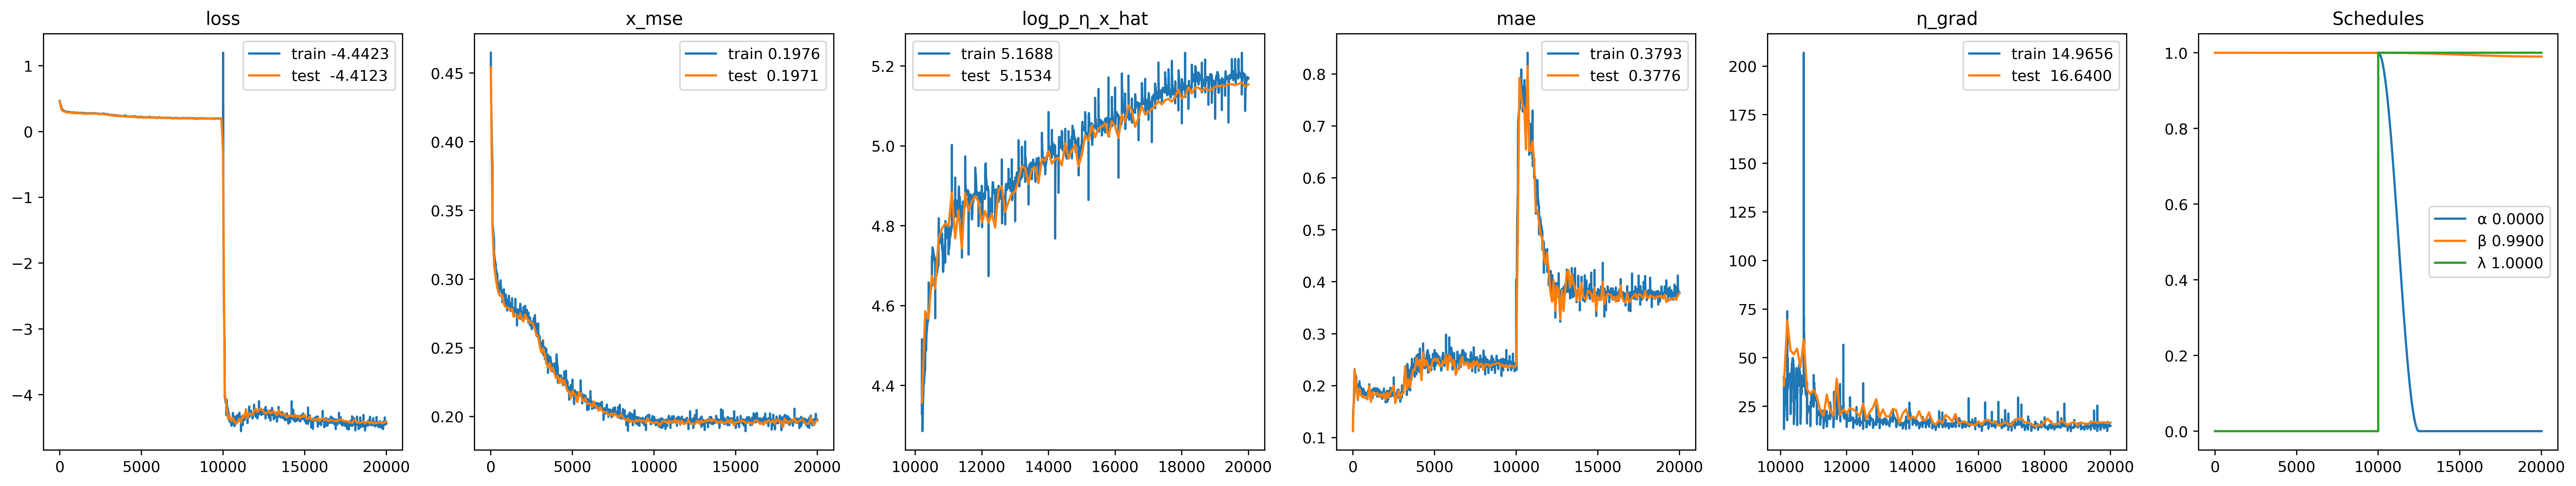

In [18]:
# plot the training history
steps, loss, x_mse, log_p_η_x_hat, mae, η_grad, λ, α, β, lr_inference, lr_generative, lr_σ, grad_norm, gen_sum, inf_sum = history.collect(
    "steps", "loss", "x_mse", "log_p_η_x_hat", "mae", "η_grad", "λ", "α", "β", "lr_inference", "lr_generative", "lr_σ", "grad_norm", "gen_sum", "inf_sum"
)
steps_test, loss_test, x_mse_test, log_p_η_x_hat_test, mae_test, η_grad_test = history.collect(
    "steps", "loss_test", "x_mse_test", "log_p_η_x_hat_test", "mae_test", "η_grad_test"
)

n_plots = 6
fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5), dpi=400)

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")
# axs[0].set_yscale("symlog")

axs[1].plot(steps, x_mse, label=f"train {x_mse[-1]:.4f}")
axs[1].plot(steps_test, x_mse_test, label=f"test  {x_mse_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("x_mse")


second_half = lambda x, b: x[len(x) // 2 + b:]

axs[2].plot(second_half(steps, 200), second_half(log_p_η_x_hat, 200), label=f"train {log_p_η_x_hat[-1]:.4f}")
axs[2].plot(second_half(steps_test, 2), second_half(log_p_η_x_hat_test, 2), label=f"test  {log_p_η_x_hat_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("log_p_η_x_hat")
# # make x axis start halfway through
# axs[2].set_xlim(steps[0] + (steps[-1] - steps[0]) / 2, steps[-1])
# # scale y axis appropriately, for x-axis bounds, by looking at the max and min values from halfway onwards
# axs[2].set_ylim(
#     min(np.min(log_p_η_x_hat[len(steps) // 2 + 200 :]), np.min(log_p_η_x_hat_test[len(steps_test) // 2 + 2:])),
#     # max(np.max(log_p_η_x_hat[len(steps) // 2 + 200 :]), np.max(log_p_η_x_hat_test[len(steps_test) // 2 + 200 :])),
# )

axs[3].plot(steps, mae, label=f"train {mae[-1]:.4f}")
axs[3].plot(steps_test, mae_test, label=f"test  {mae_test[-1]:.4f}")
axs[3].legend()
axs[3].set_title("mae")

axs[4].plot(second_half(steps, 100), second_half(η_grad, 100), label=f"train {η_grad[-1]:.4f}")
axs[4].plot(second_half(steps_test, 1), second_half(η_grad_test, 1), label=f"test  {η_grad_test[-1]:.4f}")
axs[4].legend()
axs[4].set_title("η_grad")
# make x axis start halfway through
# axs[4].set_xlim(steps[0] + (steps[-1] - steps[0]) / 2, steps[-1])

# axs[4].plot(steps, lr_inference, label=f"inf   {lr_inference[-1]:.4f}")
# axs[4].plot(steps, lr_generative, label=f"gen {lr_generative[-1]:.4f}")
# axs[4].plot(steps, lr_σ, label=f"σ     {lr_σ[-1]:.4f}")
# axs[4].legend()
# axs[4].set_title("lr")
# axs[4].set_yscale("log")

# axs[4].plot(steps, λ, label=f"{λ[-1]:.4f}")
# axs[4].legend()
# axs[4].set_title("λ")

axs[5].plot(steps, α, label=f"α {α[-1]:.4f}")
axs[5].plot(steps, β, label=f"β {β[-1]:.4f}")
axs[5].plot(steps, λ, label=f"λ {λ[-1]:.4f}")
axs[5].legend()
axs[5].set_title("Schedules")

# axs[5].plot(steps, gen_sum, label=f"gen {gen_sum[-1]:.4f}")
# axs[5].plot(steps, inf_sum, label=f"inf   {inf_sum[-1]:.4f}")
# axs[5].legend()
# axs[5].set_title("grad_sum")

plt.show()

In [19]:
# load the best model using flax checkpointing
from flax.training import checkpoints

# best_state = checkpoints.restore_checkpoint(ckpt_dir='checkpoint', target=state)
# best_state.step

In [20]:
jax.nn.softplus(final_state.params['inference_net']['σ_']).mean()

Array(8.783276e-05, dtype=float32)

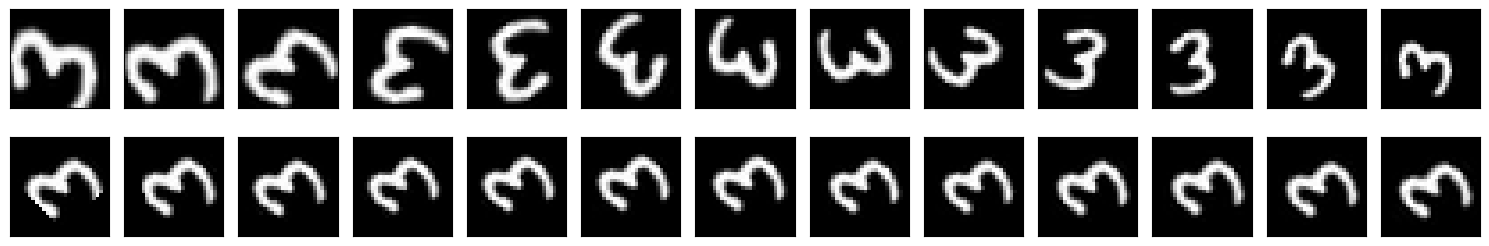

In [21]:
from src.utils.plotting import rescale_for_imshow

val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

x_ = val_batch['image'][0][14]

def get_proto(x):
    η, _ = final_state.apply_fn({"params": final_state.avg_params if final_state.avg_params is not None else final_state.params},
                            x, train=False, rngs={"sample": rng})
    xhat = transform_image(x, -η)
    return xhat, η

for mask in [
    # jnp.array([0, 0, 1, 0, 0]),
    # jnp.array([1, 1, 0, 0, 0]),
    # jnp.array([0, 0, 0, 1, 1]),
    jnp.array([1, 1, 1, 1, 1])
]:

    transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
        x_,
        jnp.linspace(-jnp.array(config.model.bounds) * mask, jnp.array(config.model.bounds) * mask, 13)
    )

    xhats, ηs = jax.vmap(get_proto)(transformed_xs)

    fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

    for ax, x in zip(axs[0], list(transformed_xs)):
        ax.imshow(rescale_for_imshow(x), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    for ax, xhat in zip(axs[1], list(xhats)):
        ax.imshow(rescale_for_imshow(xhat), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [22]:
from scipy.stats import gaussian_kde

p_H_X_hat, p_H_X_hat_vars = model.bind({"params": final_state.params}).generative_net.unbind()
q_H_X, q_H_X_vars = model.bind({"params": final_state.params}).inference_net.unbind()

# function to plot the histograms of p(η|x_hat) in each dimmension
def plot_hists(x, n=10_000):
    q_H_x = q_H_X.apply(q_H_X_vars, x)
    ηs_q, log_probs = q_H_x.sample_and_log_prob(seed=random.PRNGKey(0), sample_shape=(n))
    η = ηs_q[jnp.argmax(log_probs)]
    xhat = transform_image(x, -η)

    p_H_x_hat = p_H_X_hat.apply(p_H_X_hat_vars, xhat)
    
    ηs_p = p_H_x_hat.sample(seed=random.PRNGKey(0), sample_shape=(10_000,))

    D = p_H_x_hat.event_shape[0]
    fig, axs = plt.subplots(1, D + 2, figsize=(3*(D+2), 3))

    axs[0].imshow(rescale_for_imshow(x), cmap='gray')
    axs[1].imshow(rescale_for_imshow(xhat), cmap='gray')

    for i, ax in enumerate(axs[2:]):
        x = np.linspace(config.model.bounds[i] - 1e-5, -config.model.bounds[i] + 1e-5, 1000)

        # plot p(η|x_hat)
        ax.hist(ηs_p[:, i], bins=100, density=True, alpha=0.5, color="C0")
        kde = gaussian_kde(ηs_p[:, i])
        ax.plot(x, kde(x), color="C0")

        # make a axvline to plot η, make the line dashed
        ax.axvline(η[i], color="C1", linestyle="--")
        # make a twin axis to plot q(η|x)
        ax2 = ax.twinx()
        ax2.hist(ηs_q[:, i], bins=100, density=True, alpha=0.5, color="C1")
        kde = gaussian_kde(ηs_q[:, i])
        ax2.plot(x, kde(x), color="C1")

        ax.set_title(f"dim {i}")
        ax.set_xlim(-config.model.bounds[i], config.model.bounds[i])

    plt.tight_layout()
    plt.show()

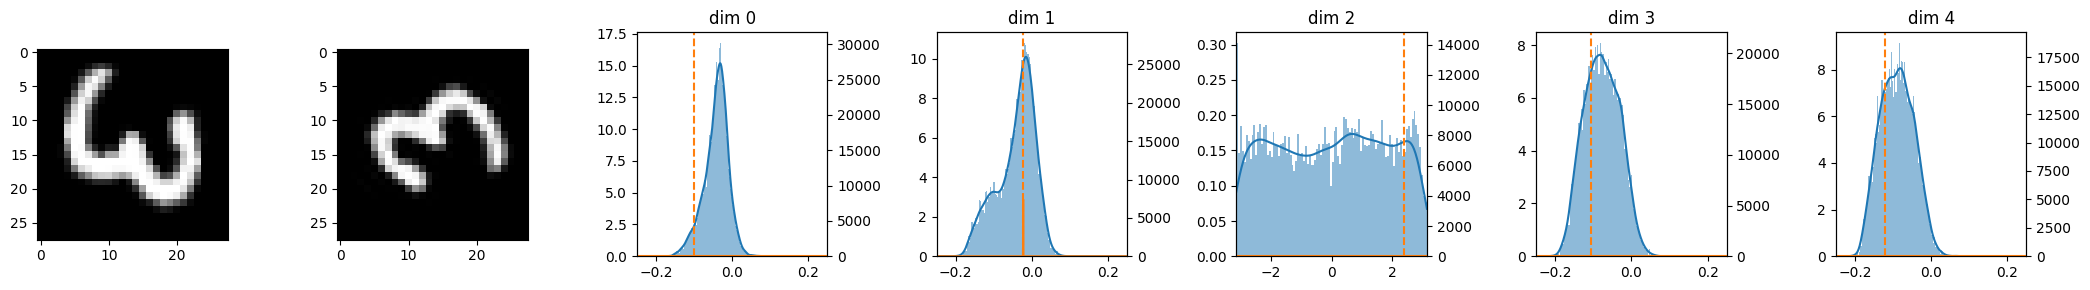

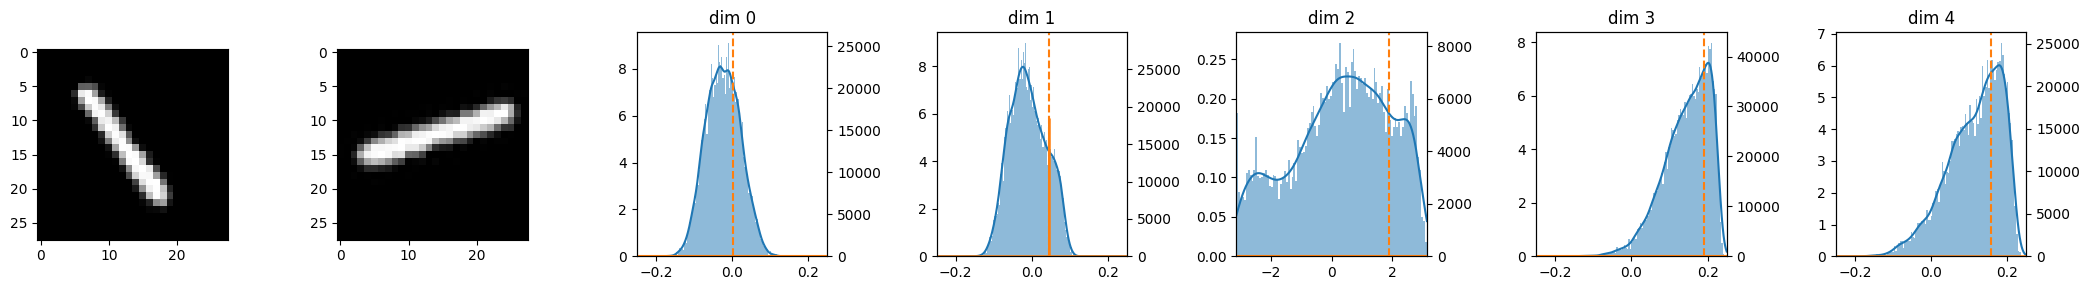

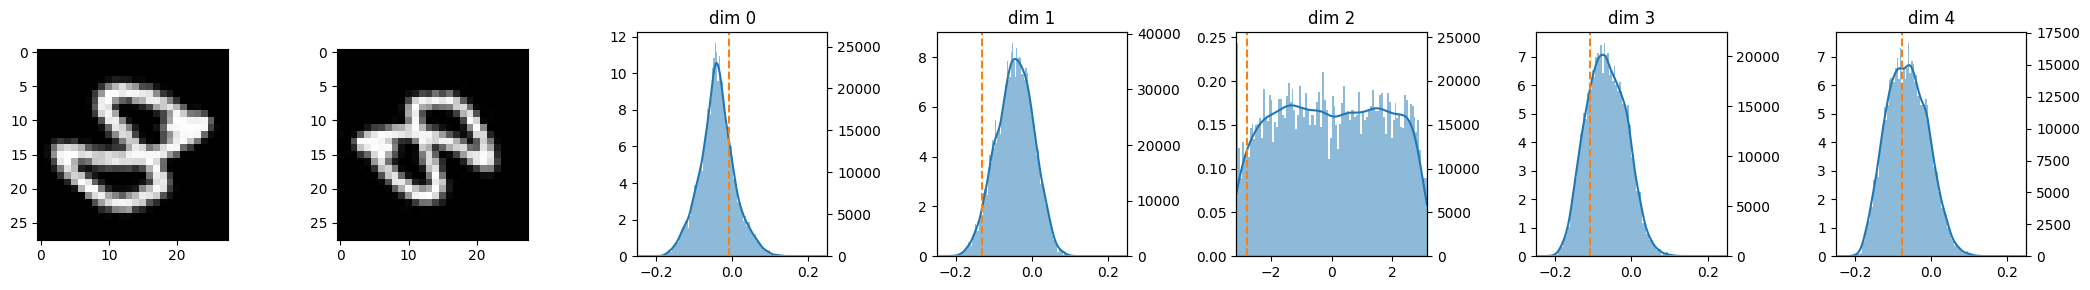

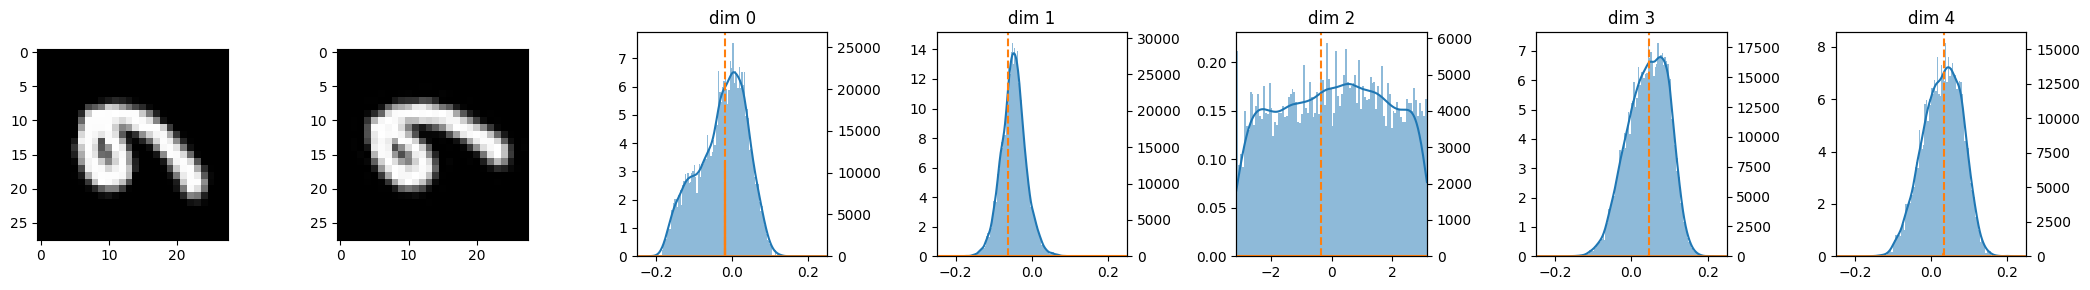

In [23]:
plot_hists(val_batch['image'][0][14], n=1_000)
plot_hists(val_batch['image'][0][1], n=1_000)
plot_hists(val_batch['image'][0][4], n=1_000)
plot_hists(val_batch['image'][0][9], n=1_000)

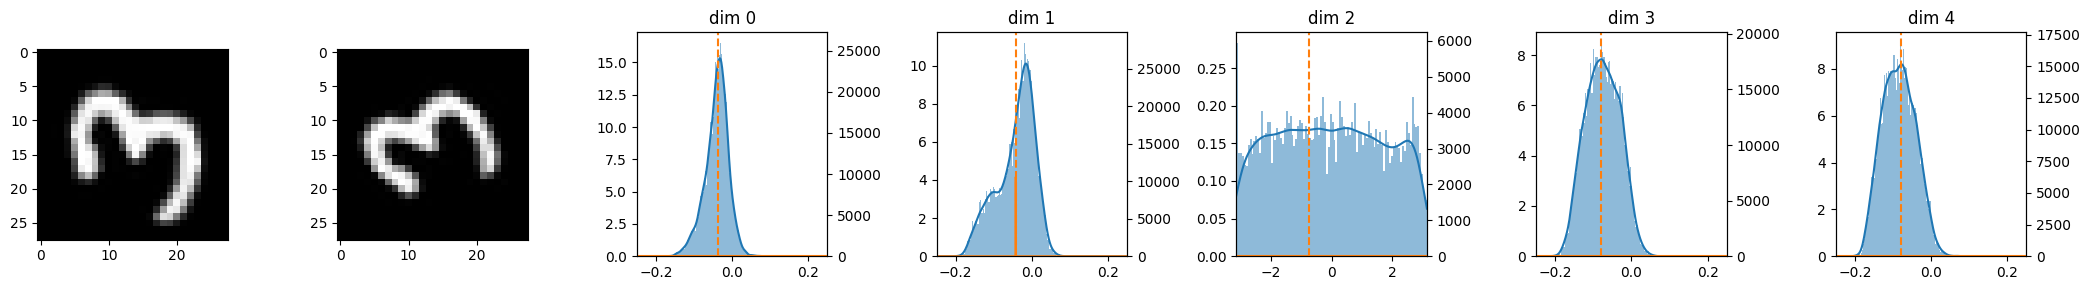

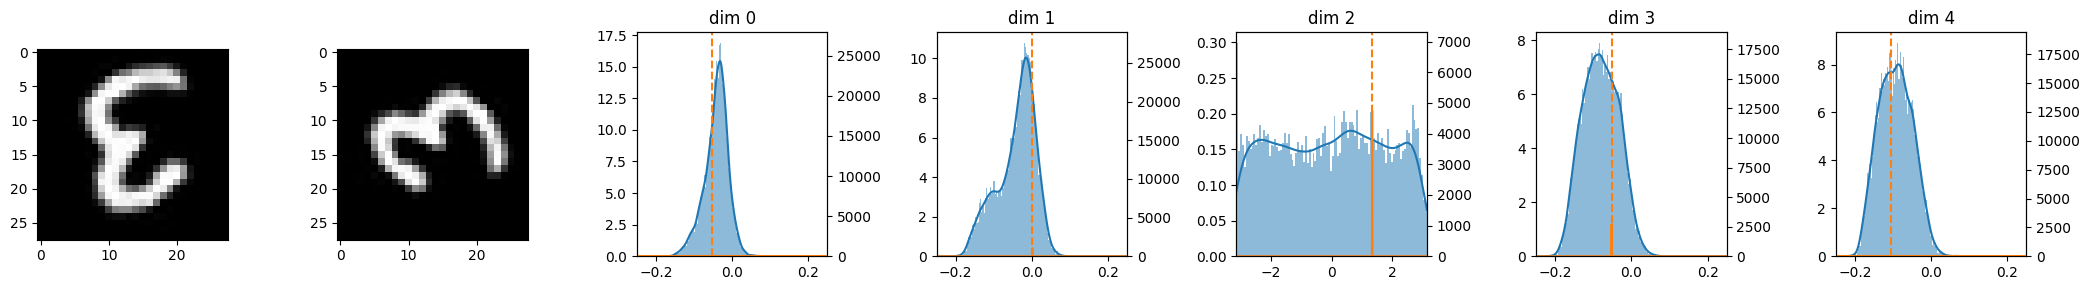

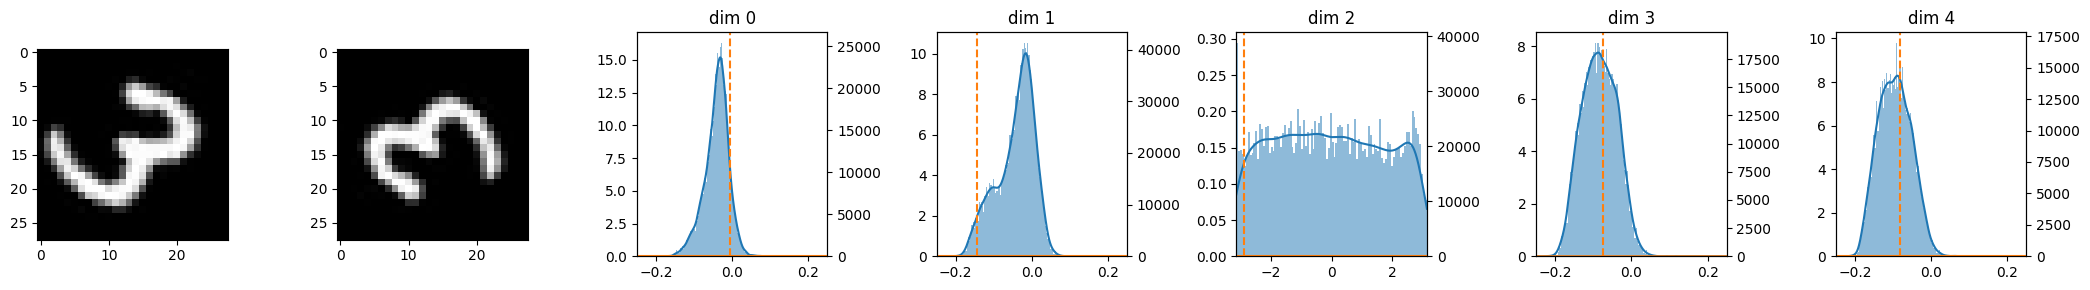

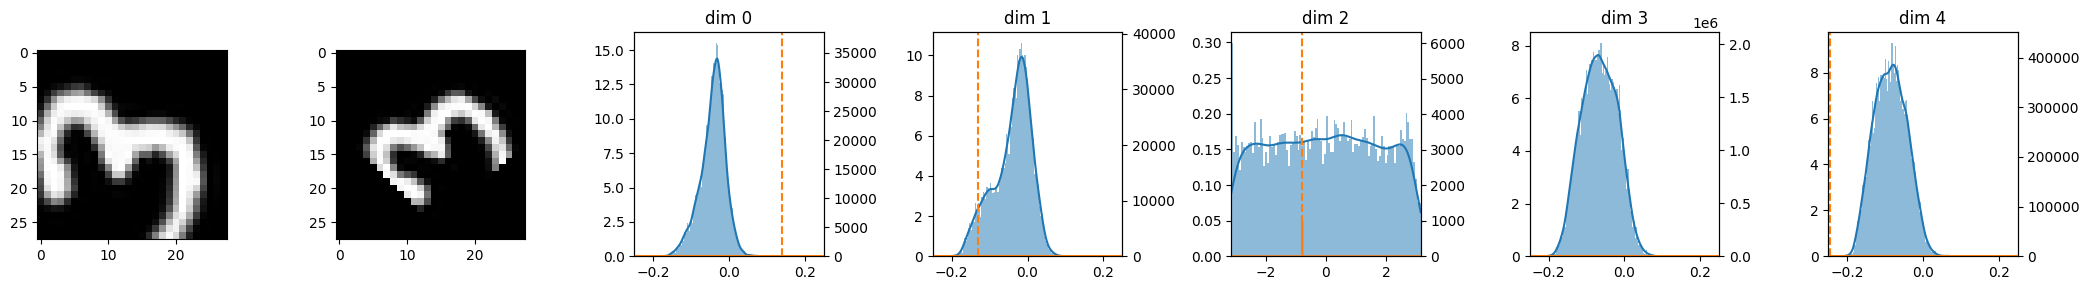

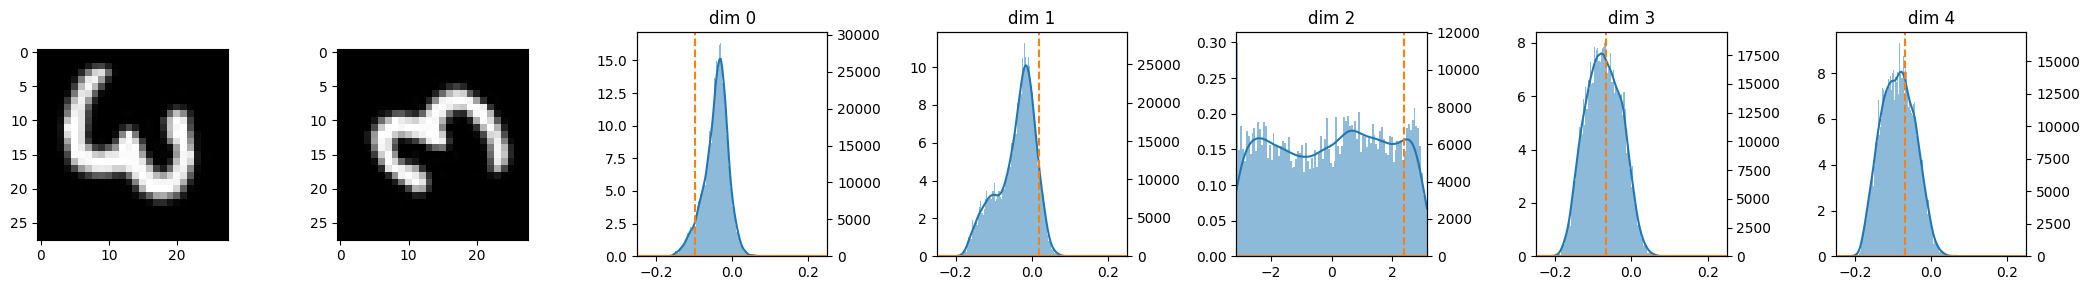

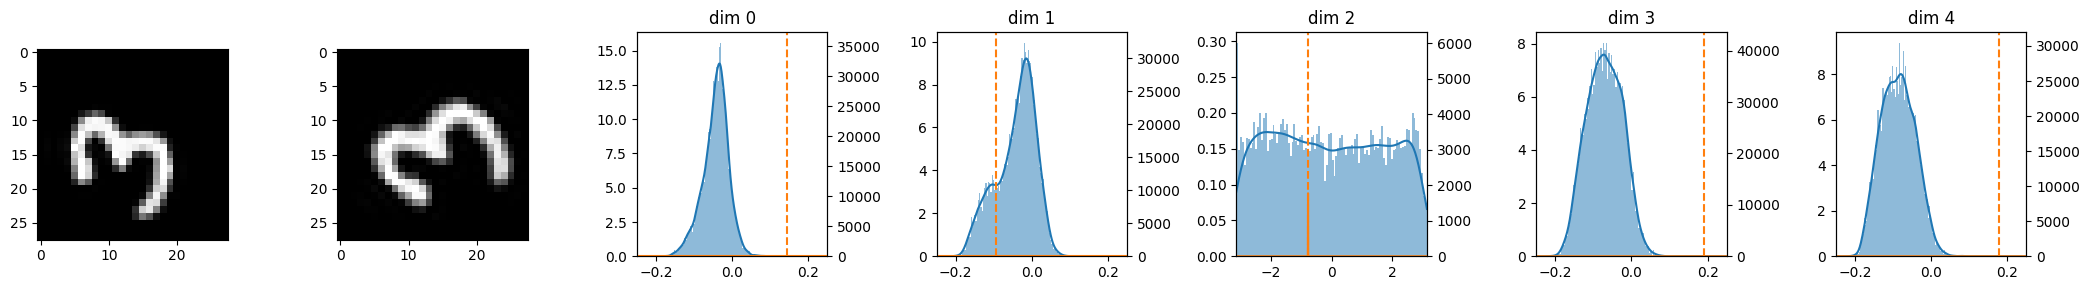

In [24]:
full_mask = jnp.array([1, 1, 1, 1, 1])
rot_mask = jnp.array([0, 0, 1, 0, 0])
transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
    x_,
    jnp.concatenate((
        jnp.linspace(-jnp.array(config.model.bounds) * rot_mask, jnp.array(config.model.bounds) * rot_mask, 4)[:3],
        jnp.linspace(-jnp.array(config.model.bounds) * full_mask, jnp.array(config.model.bounds) * full_mask, 3),
    ))
)

for x in transformed_xs:
    plot_hists(x, n=1_000)

[]

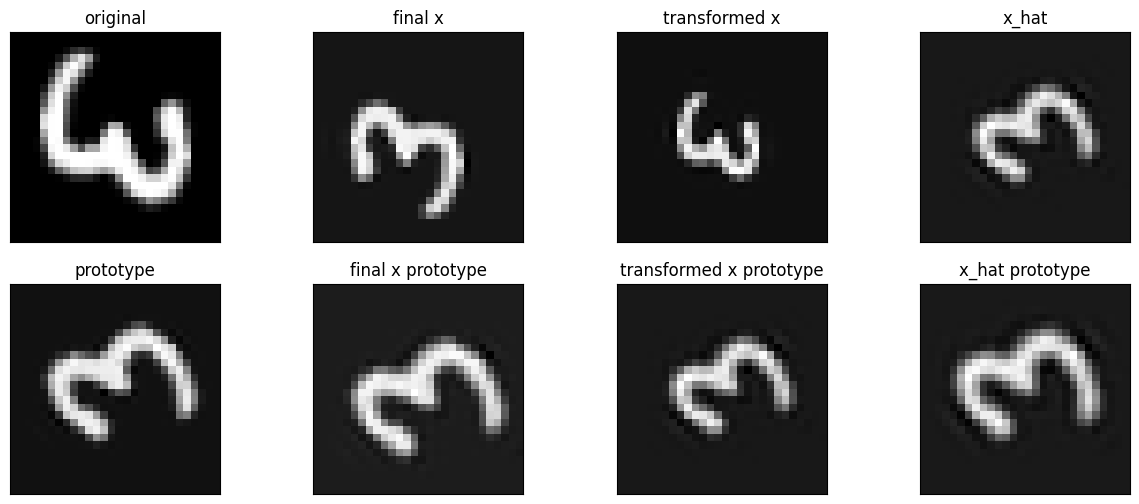

In [25]:
# make a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# plot the original image
axs[0, 0].imshow(x_, cmap='gray')
axs[0, 0].set_title("original")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(x_)
axs[1, 0].imshow(xhat, cmap='gray')
axs[1, 0].set_title("prototype")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# plot x
axs[0, 1].imshow(x, cmap='gray')
axs[0, 1].set_title("final x")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(x)
axs[1, 1].imshow(xhat, cmap='gray')
axs[1, 1].set_title("final x prototype")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

# transform again and plot the result
xx = transform_image(x, jnp.array(config.model.bounds))
axs[0, 2].imshow(xx, cmap='gray')
axs[0, 2].set_title("transformed x")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(xx)
axs[1, 2].imshow(xhat, cmap='gray')
axs[1, 2].set_title("transformed x prototype")
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

# use that xhat as x
axs[0, 3].imshow(xhat, cmap='gray')
axs[0, 3].set_title("x_hat")
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(xhat)
axs[1, 3].imshow(xhat, cmap='gray')
axs[1, 3].set_title("x_hat prototype")
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
